<a href="https://colab.research.google.com/github/rodrigolopezlopez/didi_business_case/blob/main/DIDI_business_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Intelligence Challenge**

# **1. Import libraries**

In [735]:
!pip install pmdarima

In [736]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pmdarima import auto_arima
from google.colab import files
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Format for graphs
color_pal = sns.color_palette()
%matplotlib inline

# **2. Loading data**
Retrieving data and review if data was loaded correctly

In [737]:
visitors = pd.read_csv('/content/drive/MyDrive/Data/restaurants_visitors.csv')
restaurants = pd.read_csv('/content/drive/MyDrive/Data/store_info.csv')
dates = pd.read_csv('/content/drive/MyDrive/Data/date_info.csv')

In [738]:
visitors.head()

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors
0,db80363d35f10926,2016-01-01,01/01/2016 00:00,01/01/2016 01:00,5
1,db80363d35f10926,2016-01-02,02/01/2016 01:00,01/01/2016 16:00,2
2,db80363d35f10926,2016-01-02,02/01/2016 01:00,01/01/2016 15:00,4
3,db80363d35f10926,2016-01-02,02/01/2016 18:00,02/01/2016 14:00,2
4,db80363d35f10926,2016-01-02,02/01/2016 18:00,02/01/2016 02:00,3


In [739]:
restaurants.head()

,store_id,genre_name,area_name,latitude,longitude
0,0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [740]:
dates.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


# **3. Exploratory data analysis**
Understand the structure of the data, missing values, outliers and correlations

## **3.1. Description of the data structure**

### **3.1.1. Visitors**

In [741]:
visitors.shape

(12162, 5)

In [742]:
visitors.dtypes

id                  object
visit_date          object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

### **3.1.2. Restaurants**

In [743]:
restaurants.shape

(829, 5)

In [744]:
restaurants.dtypes

store_id       object
genre_name     object
area_name      object
latitude      float64
longitude     float64
dtype: object

### **3.1.3. Dates**

In [745]:
dates.shape

(517, 3)

In [746]:
dates.dtypes

calendar_date    object
day_of_week      object
holiday_flg       int64
dtype: object

## **3.2. Identification of missing/wrong data**

### **3.2.1. Visitors**

In [747]:
visitors.isnull().sum()

id                  0
visit_date          0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [748]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12162 entries, 0 to 12161
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                12162 non-null  object
 1   visit_date        12162 non-null  object
 2   visit_datetime    12162 non-null  object
 3   reserve_datetime  12162 non-null  object
 4   reserve_visitors  12162 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 475.2+ KB


In [749]:
# Check if all date supposed columns could actually be converted to date
date_columns = ['visit_date', 'visit_datetime', 'reserve_datetime']
for i in date_columns:
  try:
    visitors[i].astype('datetime64[ns]')
  except:
    print('Wrong date format: ', i)

Wrong date format:  visit_date


In [750]:
try:
  visitors['reserve_visitors'].astype('int64')
except:
  print('Wrong date format')

In [751]:
# Once wrong value identified, check if is spread across dataset
for i, data in visitors.items():
  print(i, visitors[visitors[i] == '#VALUE!'].head(1))

id Empty DataFrame
Columns: [id, visit_date, visit_datetime, reserve_datetime, reserve_visitors]
Index: []
visit_date                     id visit_date    visit_datetime  reserve_datetime  \
1567  965b2e0cf4119003    #VALUE!  26/10/2016 20:00  25/10/2016 17:00   

      reserve_visitors  
1567                 5  
visit_datetime Empty DataFrame
Columns: [id, visit_date, visit_datetime, reserve_datetime, reserve_visitors]
Index: []
reserve_datetime Empty DataFrame
Columns: [id, visit_date, visit_datetime, reserve_datetime, reserve_visitors]
Index: []
reserve_visitors Empty DataFrame
Columns: [id, visit_date, visit_datetime, reserve_datetime, reserve_visitors]
Index: []


### **3.2.2. Restaurants**

In [752]:
restaurants.isnull().sum()

store_id      0
genre_name    0
area_name     0
latitude      0
longitude     0
dtype: int64

In [753]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   store_id    829 non-null    object 
 1   genre_name  829 non-null    object 
 2   area_name   829 non-null    object 
 3   latitude    829 non-null    float64
 4   longitude   829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [754]:
numeric_columns = ['latitude', 'longitude']
for i in numeric_columns:
  try:
    restaurants[i].astype('float')
  except:
    print('Wrong date format: ', i)

In [755]:
for i, data in restaurants.items():
  print(i, restaurants[restaurants[i] == '#VALUE!'].head(1))

store_id Empty DataFrame
Columns: [store_id, genre_name, area_name, latitude, longitude]
Index: []
genre_name Empty DataFrame
Columns: [store_id, genre_name, area_name, latitude, longitude]
Index: []
area_name Empty DataFrame
Columns: [store_id, genre_name, area_name, latitude, longitude]
Index: []
latitude Empty DataFrame
Columns: [store_id, genre_name, area_name, latitude, longitude]
Index: []
longitude Empty DataFrame
Columns: [store_id, genre_name, area_name, latitude, longitude]
Index: []


### **3.2.3. Dates**

In [756]:
dates.isnull().sum()

calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64

In [757]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   calendar_date  517 non-null    object
 1   day_of_week    517 non-null    object
 2   holiday_flg    517 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.2+ KB


In [758]:
try:
  dates['calendar_date'].astype('datetime64[ns]')
except:
  print('Wrong date format: ')

In [759]:
try:
  dates['holiday_flg'].astype('int64')
except:
  print('Wrong date format: ')

In [760]:
for i, data in dates.items():
  print(i, dates[dates[i] == '#VALUE!'].head(1))

calendar_date Empty DataFrame
Columns: [calendar_date, day_of_week, holiday_flg]
Index: []
day_of_week Empty DataFrame
Columns: [calendar_date, day_of_week, holiday_flg]
Index: []
holiday_flg Empty DataFrame
Columns: [calendar_date, day_of_week, holiday_flg]
Index: []


## **3.3. Outlier detection**

### **3.3.1. Visitors**

Text(0.5, 0, 'Number of Visitors')

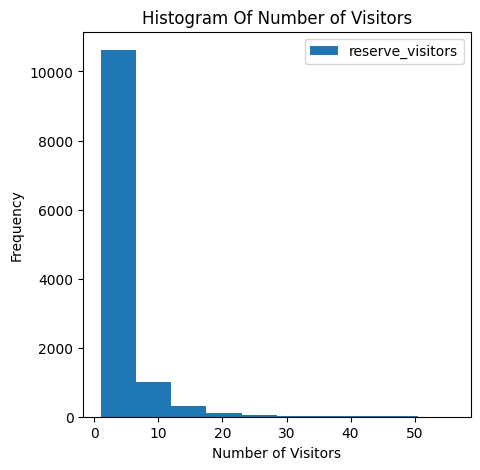

In [761]:
# Visualize possible outliers
visitors.plot(kind='hist', title='Histogram Of Number of Visitors', figsize=(5,5))
plt.xlabel('Number of Visitors')

<Axes: xlabel='reserve_visitors'>

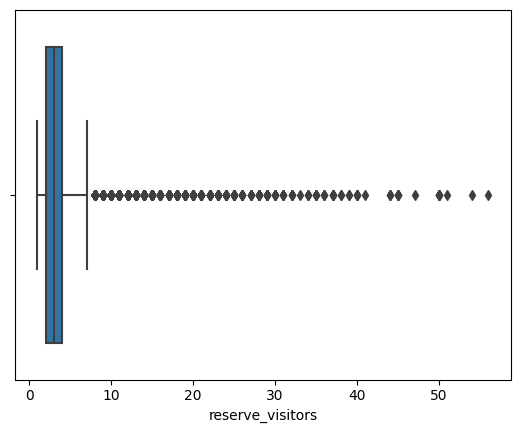

In [762]:
sns.boxplot(data = visitors, x = 'reserve_visitors')

In [763]:
# General statistics from dataset
visitors.describe()

,reserve_visitors
count,12162.000000
mean,4.040701
std,4.141749
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,56.000000


### **3.3.2. Restaurants**

array([[<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>]], dtype=object)

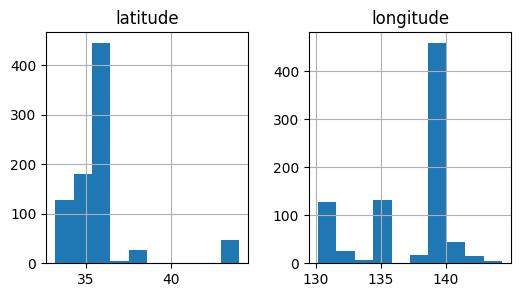

In [764]:
restaurants.hist(figsize=(6,3))

<Axes: xlabel='latitude'>

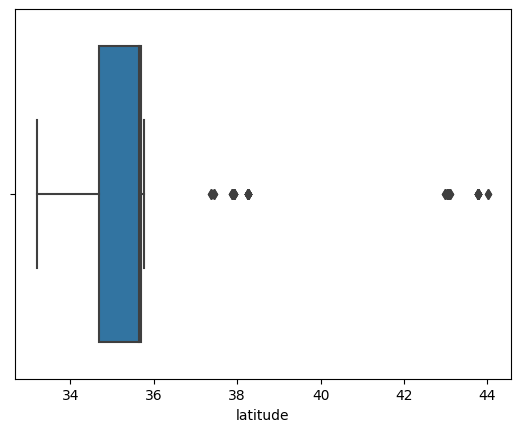

In [765]:
sns.boxplot(data = restaurants, x = 'latitude')

<Axes: xlabel='longitude'>

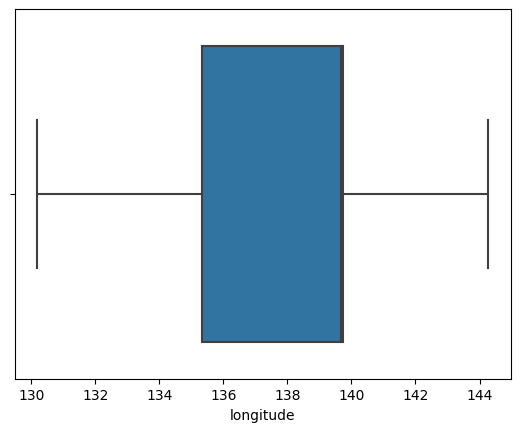

In [766]:
sns.boxplot(data = restaurants, x = 'longitude')

In [767]:
restaurants.describe()

,latitude,longitude
count,829.000000,829.000000
mean,35.647042,137.415311
std,2.084659,3.650971
min,33.211967,130.195555
25%,34.695124,135.341564
50%,35.658068,139.685474
75%,35.694003,139.751599
max,44.020632,144.273398


### **3.3.3. Dates**

array([[<Axes: title={'center': 'holiday_flg'}>]], dtype=object)

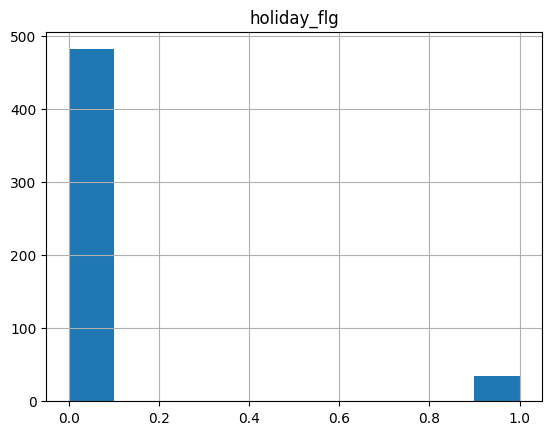

In [768]:
dates.hist()

In [769]:
dates.describe()

,holiday_flg
count,517.000000
mean,0.067698
std,0.251471
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## **3.4. Identification of relationships between variable pairs**
As having just or two numeric variables within the data sets, correlation at this point is not giving us insights, but let it in this section as a good general practice for any dataset correlation detection

In [770]:
visitors.corr()

<ipython-input-770-3440603d946e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  visitors.corr()


,reserve_visitors
reserve_visitors,1.0


In [771]:
restaurants.corr()

<ipython-input-771-d1e36aa08e45>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  restaurants.corr()


,latitude,longitude
latitude,1.000000,0.644706
longitude,0.644706,1.000000


In [772]:
dates.corr()

<ipython-input-772-7a75131a3236>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dates.corr()


,holiday_flg
holiday_flg,1.0


# **4. Data wrangling**
Once understood the dataset structure, now is time to give a better format to our data and correct missing values

## **4.1. Data format**

In [773]:
visitors.head()

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors
0,db80363d35f10926,2016-01-01,01/01/2016 00:00,01/01/2016 01:00,5
1,db80363d35f10926,2016-01-02,02/01/2016 01:00,01/01/2016 16:00,2
2,db80363d35f10926,2016-01-02,02/01/2016 01:00,01/01/2016 15:00,4
3,db80363d35f10926,2016-01-02,02/01/2016 18:00,02/01/2016 14:00,2
4,db80363d35f10926,2016-01-02,02/01/2016 18:00,02/01/2016 02:00,3


In [774]:
visitors.dtypes

id                  object
visit_date          object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

In [775]:
# Change to date format to date columns
# From visit_datetime create visit_date to overwrite the missing values with the correct values
visitors["visit_date"] = pd.to_datetime(visitors["visit_datetime"].str.slice(start=0, stop=10), format="%d/%m/%Y")
visitors["visit_datetime"] = pd.to_datetime(visitors["visit_datetime"], format="%d/%m/%Y %H:%M")
visitors["reserve_datetime"] = pd.to_datetime(visitors["reserve_datetime"], format="%d/%m/%Y %H:%M")
visitors

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors
0,db80363d35f10926,2016-01-01,2016-01-01 00:00:00,2016-01-01 01:00:00,5
1,db80363d35f10926,2016-01-02,2016-01-02 01:00:00,2016-01-01 16:00:00,2
2,db80363d35f10926,2016-01-02,2016-01-02 01:00:00,2016-01-01 15:00:00,4
3,db80363d35f10926,2016-01-02,2016-01-02 18:00:00,2016-01-02 14:00:00,2
4,db80363d35f10926,2016-01-02,2016-01-02 18:00:00,2016-01-02 02:00:00,3
...,...,...,...,...,...
12157,3cad29d1a23209d2,2017-05-27,2017-05-27 21:00:00,2017-02-09 18:00:00,3
12158,1033310359ceeac1,2017-05-28,2017-05-28 23:00:00,2017-04-15 22:00:00,2
12159,1033310359ceeac1,2017-05-28,2017-05-28 23:00:00,2017-04-18 17:00:00,2
12160,1033310359ceeac1,2017-05-30,2017-05-30 23:00:00,2017-04-19 17:00:00,8


In [776]:
# Now all the columns have the correct format and not missing values
visitors.dtypes

id                          object
visit_date          datetime64[ns]
visit_datetime      datetime64[ns]
reserve_datetime    datetime64[ns]
reserve_visitors             int64
dtype: object

## **4.2. Delete duplicate rows**

In [777]:
# Drop all duplicate rows
visitors = visitors.drop_duplicates()

In [778]:
visitors

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors
0,db80363d35f10926,2016-01-01,2016-01-01 00:00:00,2016-01-01 01:00:00,5
1,db80363d35f10926,2016-01-02,2016-01-02 01:00:00,2016-01-01 16:00:00,2
2,db80363d35f10926,2016-01-02,2016-01-02 01:00:00,2016-01-01 15:00:00,4
3,db80363d35f10926,2016-01-02,2016-01-02 18:00:00,2016-01-02 14:00:00,2
4,db80363d35f10926,2016-01-02,2016-01-02 18:00:00,2016-01-02 02:00:00,3
...,...,...,...,...,...
12157,3cad29d1a23209d2,2017-05-27,2017-05-27 21:00:00,2017-02-09 18:00:00,3
12158,1033310359ceeac1,2017-05-28,2017-05-28 23:00:00,2017-04-15 22:00:00,2
12159,1033310359ceeac1,2017-05-28,2017-05-28 23:00:00,2017-04-18 17:00:00,2
12160,1033310359ceeac1,2017-05-30,2017-05-30 23:00:00,2017-04-19 17:00:00,8


# **5. Reserve visitors forecast**
Having our dataset already clean is ready to start creating insights from it, with graphs, tables, models, etc

Text(0, 0.5, 'Number of visitors')

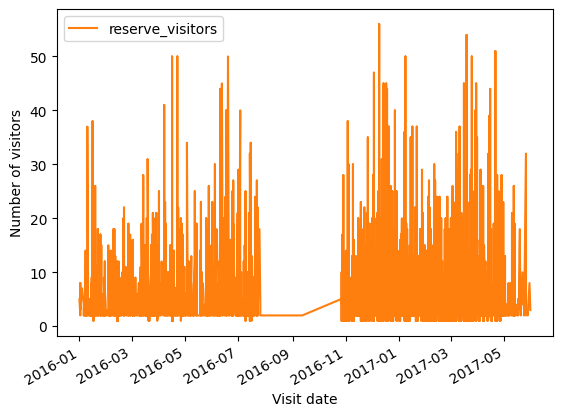

In [779]:
# Firts we will plot our two target variables
visitors.plot(x = 'visit_date', y = 'reserve_visitors', color = color_pal[1])
plt.xlabel('Visit date')
plt.ylabel('Number of visitors')

Text(0, 0.5, 'Number of visitors')

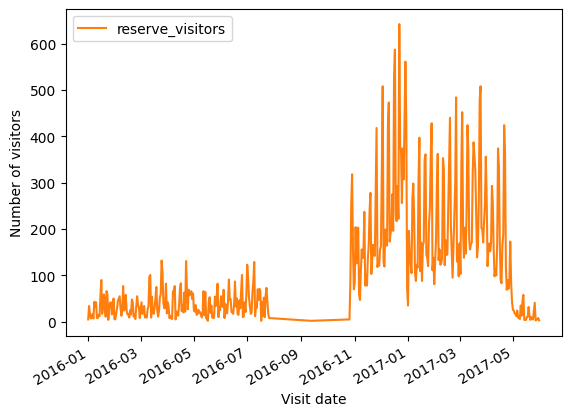

In [780]:
# Let's create a better ploting from the previous graph as aggregating the reserve visitors per day
columns = ['visit_date', 'reserve_visitors']
visitors_forecast = visitors[columns].copy()
visitors_forecast = visitors_forecast.groupby(['visit_date']).sum()
visitors_forecast.plot(color = color_pal[1])
plt.xlabel("Visit date")
plt.ylabel("Number of visitors")

In [781]:
visitors_forecast.head()

,reserve_visitors
visit_date,
2016-01-01,5
2016-01-02,34
2016-01-03,17
2016-01-04,7
2016-01-06,17


In [782]:
visitors_forecast.tail()

,reserve_visitors
visit_date,
2017-05-26,41
2017-05-27,3
2017-05-28,4
2017-05-30,8
2017-05-31,3


Text(0, 0.5, 'Number of visitors')

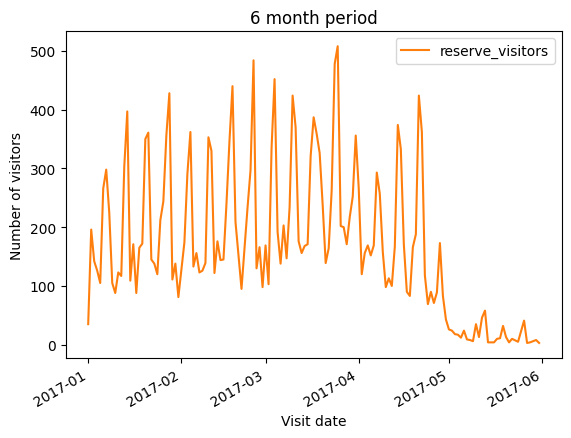

In [783]:
# Reviewing a 6 month period
visitors_forecast[(visitors_forecast.index >= '2017-01-01') & (visitors_forecast.index <= '2017-07-01')].plot(title = '6 month period', color = color_pal[1])
plt.xlabel("Visit date")
plt.ylabel("Number of visitors")

Text(0, 0.5, 'Number of visitors')

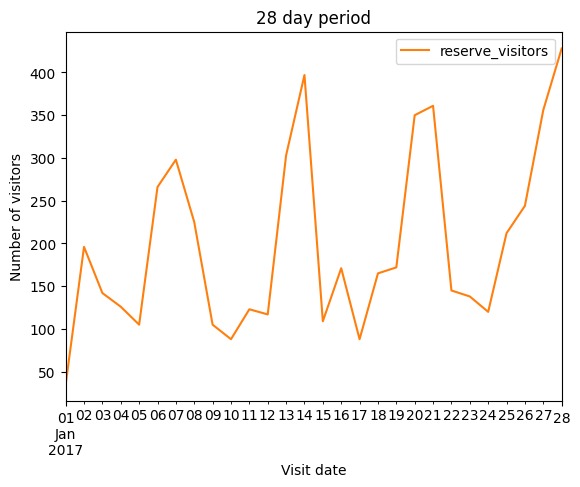

In [784]:
visitors_forecast[(visitors_forecast.index >= '2017-01-01') & (visitors_forecast.index <= '2017-01-28')].plot(title = '28 day period', color = color_pal[1])
plt.xlabel("Visit date")
plt.ylabel("Number of visitors")

In [785]:
visitors_forecast['dayofweek'] = visitors_forecast.index.dayofweek
visitors_forecast['month'] = visitors_forecast.index.month

In [786]:
# Download the file
visitors_forecast.to_csv('output.csv', encoding = 'utf-8-sig')
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='month', ylabel='reserve_visitors'>

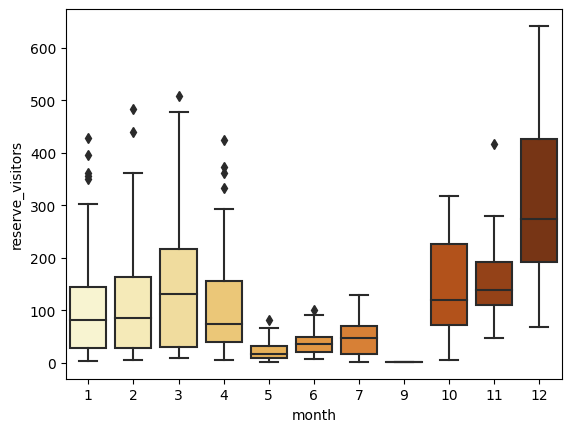

In [787]:
# Visualizing behavior per month
sns.boxplot(data = visitors_forecast, x = 'month', y = 'reserve_visitors', palette = 'YlOrBr')

<Axes: xlabel='dayofweek', ylabel='reserve_visitors'>

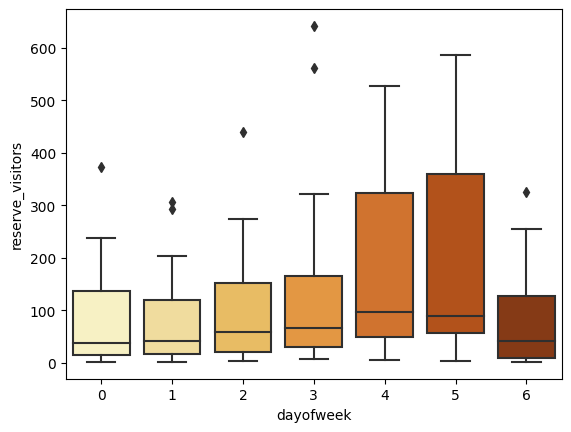

In [788]:
# Visualizing behavior per day of week
sns.boxplot(data = visitors_forecast, x = 'dayofweek', y = 'reserve_visitors', palette = 'YlOrBr')

## **5.1. SARIMA model**

In [789]:
visitors_forecast.tail()

,reserve_visitors,dayofweek,month
visit_date,,,
2017-05-26,41,4,5
2017-05-27,3,5,5
2017-05-28,4,6,5
2017-05-30,8,1,5
2017-05-31,3,2,5


In [790]:
train = visitors_forecast[visitors_forecast.index < '2017-05-01']
test = visitors_forecast[visitors_forecast.index >= '2017-05-01']

In [791]:
model = auto_arima(y = train.reserve_visitors, m = 7)

In [792]:
date = pd.date_range('2017-05-01', periods=31, freq="D")
date = pd.Series(range(len(date)), index=date)

In [793]:
predictions = pd.Series(model.predict(n_periods = 31))
predictions.index = date.index
predictions[-1]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


-24.99197728303472

Text(0.5, 0, 'Visit date')

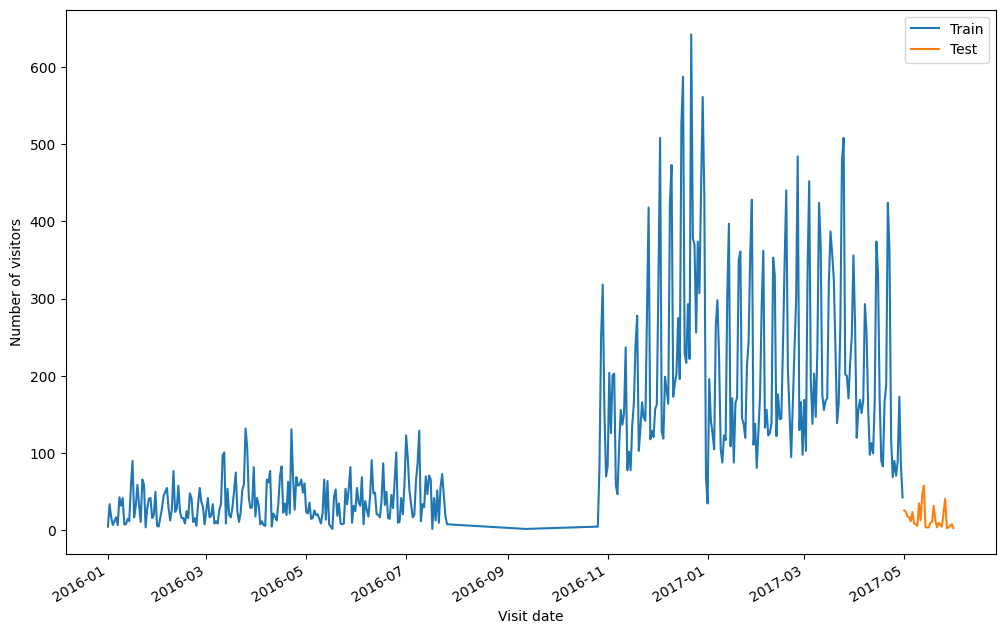

In [798]:
train['reserve_visitors'].plot(figsize = (12, 8), legend = True, label = 'Train')
test['reserve_visitors'].plot(legend = True, label = 'Test')
plt.ylabel("Number of visitors")
plt.xlabel("Visit date")
#predictions.plot(legend = True)

In [795]:
test = test.drop(columns = ['dayofweek', 'month'])

In [796]:
accuracy = test[['reserve_visitors']]
accuracy = accuracy.rename(columns={'reserve_visitors': 'actual'})
accuracy['predictions'] = predictions
accuracy['error'] = accuracy.actual - accuracy.predictions
accuracy['error'] = accuracy['error'].abs()
accuracy['error'] = accuracy.error/accuracy.actual

In [797]:
# We calculate our MAPE
accuracy.error.mean()*100

459.2132859461783